In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, GRU
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from datetime import date, timedelta
import time
import datetime
from tensorflow import keras
from keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [3]:
hist = pd.read_csv('/content/drive/MyDrive/S7 Project/BTC.csv')
hist = hist.drop(['Number of trades'], axis=1)
hist = hist.drop(['Close time'], axis=1)
hist = hist.drop(['Quote asset volume'], axis=1)
hist = hist.drop(['Taker buy base asset volume'], axis=1)
hist = hist.drop(['Taker buy quote asset volume'], axis=1)
# hist = hist.drop(['Volume'], axis=1)
target_col = 'Close'
hist['Open time'] = pd.to_datetime(hist['Open time']/1000, unit='s')
hist = hist.set_index('Open time')

In [4]:
hist

,Open,High,Low,Close,Volume
Open time,,,,,
2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061
2017-08-17 04:15:00,4261.48,4270.41,4261.32,4261.45,9.119865
2017-08-17 04:30:00,4280.00,4310.07,4267.99,4310.07,21.923552
2017-08-17 04:45:00,4310.07,4313.62,4291.37,4308.83,13.948531
2017-08-17 05:00:00,4308.83,4328.69,4304.31,4304.31,5.101153
...,...,...,...,...,...
2021-09-27 17:15:00,43137.05,43240.01,42970.55,42981.75,313.482490
2021-09-27 17:30:00,42981.76,43157.33,42923.52,43083.49,293.079110
2021-09-27 17:45:00,43083.48,43113.71,42960.14,43049.47,218.085500


In [5]:
print(hist.iloc[4278])

Open      4378.490000
High      4378.490000
Low       4339.000000
Close     4360.000000
Volume      13.195468
Name: 2017-10-01 00:00:00, dtype: float64


In [6]:
print(hist.iloc[47891])

Open      3688.940000
High      3707.500000
Low       3684.220000
Close     3702.900000
Volume     419.980955
Name: 2018-12-31 23:45:00, dtype: float64


In [7]:
hist = hist[4278:47892]

In [8]:
hist

,Open,High,Low,Close,Volume
Open time,,,,,
2017-10-01 00:00:00,4378.49,4378.49,4339.00,4360.00,13.195468
2017-10-01 00:15:00,4345.15,4377.84,4340.01,4340.01,6.364818
2017-10-01 00:30:00,4340.01,4360.00,4337.00,4340.00,16.289272
2017-10-01 00:45:00,4340.00,4360.00,4337.00,4345.95,13.121092
2017-10-01 01:00:00,4350.00,4350.00,4320.05,4344.95,5.489526
...,...,...,...,...,...
2018-12-31 22:45:00,3684.09,3687.02,3677.45,3686.43,190.685461
2018-12-31 23:00:00,3685.54,3700.00,3685.01,3695.85,261.022071
2018-12-31 23:15:00,3695.82,3703.12,3693.87,3698.09,249.189081


In [9]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [10]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [INR]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [11]:
train, test = train_test_split(hist, test_size=0.2)

In [12]:
train

,Open,High,Low,Close,Volume
Open time,,,,,
2017-10-01 00:00:00,4378.49,4378.49,4339.00,4360.00,13.195468
2017-10-01 00:15:00,4345.15,4377.84,4340.01,4340.01,6.364818
2017-10-01 00:30:00,4340.01,4360.00,4337.00,4340.00,16.289272
2017-10-01 00:45:00,4340.00,4360.00,4337.00,4345.95,13.121092
2017-10-01 01:00:00,4350.00,4350.00,4320.05,4344.95,5.489526
...,...,...,...,...,...
2018-10-01 16:15:00,6549.15,6564.92,6541.00,6564.85,255.916387
2018-10-01 16:30:00,6561.10,6602.18,6561.10,6602.18,575.218498
2018-10-01 16:45:00,6599.38,6603.41,6585.40,6592.00,365.847377


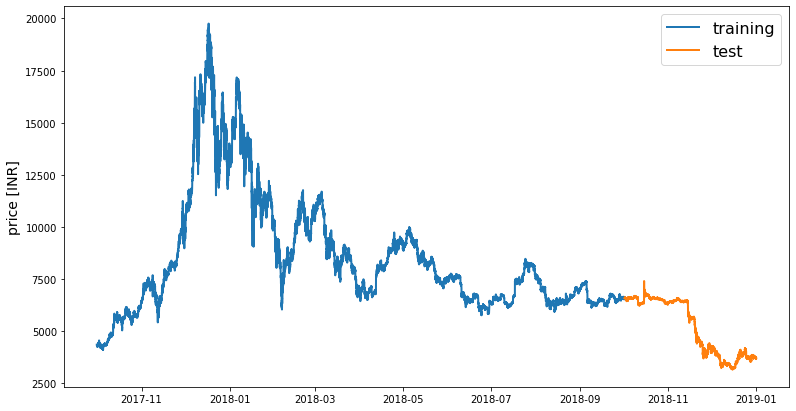

In [13]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [14]:
def normalise_zero_base(df):
    return df/df.max()

In [15]:
def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [16]:
def extract_window_data(df, window_len=20, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [17]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [18]:
window_len = 20
test_size = 0.2
zero_base = True
lstm_neurons = 32
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'Nadam'

In [19]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [20]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [21]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
1090/1090 [==============================] - 14s 8ms/step - loss: 0.0045
Epoch 2/100
1090/1090 [==============================] - 10s 9ms/step - loss: 5.6960e-04
Epoch 3/100
1090/1090 [==============================] - 9s 8ms/step - loss: 5.0705e-04
Epoch 4/100
1090/1090 [==============================] - 9s 8ms/step - loss: 4.4969e-04
Epoch 5/100
1090/1090 [==============================] - 9s 8ms/step - loss: 3.8877e-04
Epoch 6/100
1090/1090 [==============================] - 9s 8ms/step - loss: 3.0940e-04
Epoch 7/100
1090/1090 [==============================] - 9s 8ms/step - loss: 2.6953e-04
Epoch 8/100
1090/1090 [==============================] - 9s 8ms/step - loss: 2.3261e-04
Epoch 9/100
1090/1090 [==============================] - 9s 8ms/step - loss: 2.0425e-04
Epoch 10/100
1090/1090 [==============================] - 9s 8ms/step - loss: 1.8136e-04
Epoch 11/100
1090/1090 [==============================] - 9s 8ms/step - loss: 1.5862e-04
Epoch 12/100
1090/1090 [========

In [23]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.002519473126296143

In [24]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

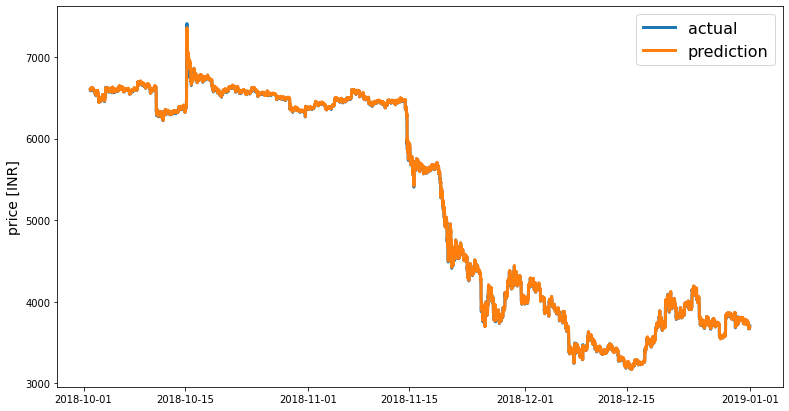

In [25]:
line_plot(targets, preds, 'actual', 'prediction', lw=3)


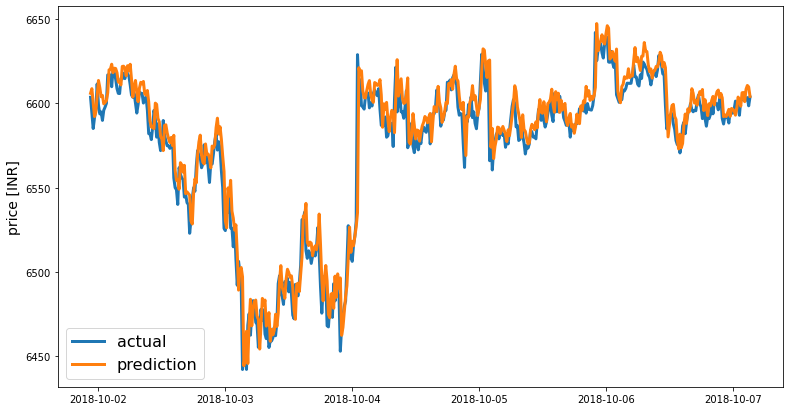

In [33]:
line_plot(targets[:500], preds[:500], 'actual', 'prediction', lw=3)


In [27]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(targets, preds , squared=False)
print("rmse: " +str(rmse))

rmse: 19.913720942083955


In [28]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(targets, preds , squared=True)
print("mse: " +str(mse))

mse: 396.5562817591931


In [29]:
mape=sum(abs((targets-preds)/targets))/len(targets)
print("mape: " +str(mape))

mape: 0.0025254259328276697
